In [12]:
''' Sanity check how the original models behave/ if they are trained sufficiently'''

' Sanity check how the original models behave/ if they are trained sufficiently'

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import sys
import os
sys.path.append('../../acd/acd')
sys.path.append('../../acd/visualization')
sys.path.append('../../acd/acd/util')
sys.path.append('../../acd/acd/scores')
sys.path.append('../../acd/acd/agglomeration')
import viz_1d as viz
import tiling_1d as tiling
import agg_1d as agg
import cd
import score_funcs
sys.path.append('../../acd')
sys.path.append('../../acd/dsets/sst')
from dsets.sst import dset
from dsets.sst.model import LSTMSentiment

# check out how two models differ
import torch.optim as O
import torch.nn as nn

from torchtext import data
from torchtext import datasets
from os.path import join

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load data and model

In [14]:
model_path = "../models/init_models"
model_list = os.listdir(model_path)
model1 = torch.load(join(model_path, model_list[0]), map_location=torch.device(0)).eval()
# model2 = torch.load(join(model_path, model_list[1]), map_location=torch.device(0))
model2 = torch.load(join(model_path, model_list[1]), map_location=torch.device(0)).eval()

In [4]:
vector_cache = '../data/.vector_cache/input_vectors.pt'
word_vectors ='glove.6B.300d'
batch_size = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
inputs = data.Field(lower= True)
answers = data.Field(sequential=False, unk_token=None)

train, dev, test = datasets.SST.splits(inputs, answers, fine_grained=False, train_subtrees=True,
                                       filter_pred=lambda ex: ex.label != 'neutral')

In [ ]:
#put this in script
inputs.build_vocab(train, dev, test)
if word_vectors:
    if os.path.isfile(vector_cache):
        inputs.vocab.vectors = torch.load(vector_cache)
    else:
        inputs.vocab.load_vectors(word_vectors)
        os.makedirs(os.path.dirname(vector_cache), exist_ok=True)
        torch.save(inputs.vocab.vectors,vector_cache)
answers.build_vocab(train)

train_iter, dev_iter, test_iter = data.BucketIterator.splits( # batches things of similar length together 
    (train, dev, test), batch_size=batch_size, device=torch.device(0)) # less padding required

In [7]:
for i, m in enumerate([model1, model2]):
    dev_iter.init_epoch()
    criterion = nn.CrossEntropyLoss()
    n_dev_correct, dev_loss = 0, 0
    cur_idx = 0
    for dev_batch_idx, dev_batch in enumerate(dev_iter):
        answer1 = m(dev_batch)
        answer2  = m(dev_batch)
        cur_idx+=dev_batch.label.shape[0]
        n_dev_correct += (((torch.max(answer1, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data))).sum()
        dev_loss = criterion(answer1, dev_batch.label)
    dev_acc = 100. * n_dev_correct / len(dev)
    print('model', i, 'acc: ', dev_acc.item(), 'loss:', dev_loss.item())

model 0 acc:  83 loss: 0.2822088897228241
model 1 acc:  83 loss: 0.30571115016937256


# Union accuracy

In [8]:
# Model 1
dev_iter.init_epoch()
# check out how two models differ

with torch.no_grad():
    criterion = nn.CrossEntropyLoss()
    n_dev_correct, dev_loss = 0, 0
    cur_idx = 0
    for dev_batch_idx, dev_batch in enumerate(dev_iter):

        answer1 = model1(dev_batch)
        answer2  = model2(dev_batch)


        cur_idx+=dev_batch.label.shape[0]
        n_dev_correct += (((torch.max(answer1, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data)+
        (torch.max(answer2, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data))>=1).sum()
        dev_loss = criterion(answer1, dev_batch.label)
    dev_acc = 100. * n_dev_correct / len(dev)
    print(dev_acc.item())

87


# Check alignment


In [9]:

is_correct = np.zeros((2,len(dev)))
correct_label =np.zeros_like(is_correct[0])
with torch.no_grad():
    # check out how two models differ
    dev_iter.init_epoch()
    import torch.optim as O
    import torch.nn as nn
    criterion = nn.CrossEntropyLoss()
    n_dev_correct, dev_loss = 0, 0
    cur_idx = 0
    for dev_batch_idx, dev_batch in enumerate(dev_iter):

        answer1 = nn.functional.softmax(model1(dev_batch), dim =1)
        answer2  = nn.functional.softmax(model2(dev_batch), dim =1)
        is_correct[0, cur_idx:cur_idx + dev_batch.label.shape[0]] = answer1[:,0].cpu().numpy() #(torch.max(answer1, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data).cpu().numpy()
        is_correct[1, cur_idx:cur_idx + dev_batch.label.shape[0]] =  answer2[:,0].cpu().numpy()#(torch.max(answer2, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data).cpu().numpy()
        correct_label[cur_idx:cur_idx + dev_batch.label.shape[0]] =dev_batch.label.cpu().numpy()
        cur_idx+=dev_batch.label.shape[0]
        n_dev_correct += (((torch.max(answer1, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data)+
        (torch.max(answer2, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data))>=1).sum()
        dev_loss = criterion(answer1, dev_batch.label)
    dev_acc = 100. * n_dev_correct / len(dev)

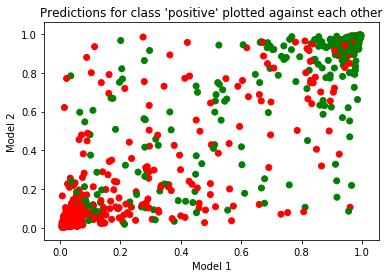

In [10]:
plt.scatter(is_correct[0], is_correct[1], c=['r' if x==1 else 'g' for x in correct_label])
plt.title("Predictions for class 'positive' plotted against each other")
#plt.savefig("Plot_train_set")
plt.ylabel("Model 2");
plt.xlabel("Model 1");